<a href="https://colab.research.google.com/github/dalexa10/Python_Data_Science/blob/main/Simulations_Subatomic_Level/visualize_wfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyscf pyqmc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 5.8 MB/s eta 0:00:00


In [3]:
import pyscf
import pyqmc.api as pyq
import numpy as np
import pyscf.mcscf
import matplotlib.pyplot as plt

## These define the plotting range
xmin = -2
xmax = 2
ymin = -3
ymax = 6


def run_scan(mol, wf):
    nconf=10
    xval = 2.0
    coords = pyq.initial_guess(mol, nconf)
    data, coords = pyq.vmc(wf, coords, nblocks=1)
    coords.configs[:,1,0]=xval
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X,Y = np.meshgrid(x,y)
    wfval = np.zeros((nconf,np.prod(X.shape)))
    wf.recompute(coords)
    baseval = wf.value()

    for i, (x,y) in enumerate(zip(X.flatten(), Y.flatten())):
        epos = coords.electron(0)
        epos.configs[:,:] = np.array([xval,x,y])[np.newaxis,:]
        testval, tmp = wf.testvalue(0,epos)
        wfval[:,i] = testval*baseval[0]*np.exp(baseval[1])

    return coords, wfval, X, Y


def make_plot(coords, wfval, X, Y, outfile=None):
    cs=list(range(4))
    fig, axes = plt.subplots(1, len(cs), figsize=(len(cs)*4,8), sharey=True)
    maval = np.max(wfval)
    for c, ax in zip(cs, axes):
        cmap = ax.imshow(np.abs(wfval[c].reshape(X.shape))**2, origin = 'lower', extent=(xmin,xmax,ymin,ymax), cmap='Blues')
        for xy in coords.configs[c,1:]:
            ax.plot(xy[1],xy[2],marker='o', color='r', mew=1, mec='k', markersize=5)
        for atompos in mol.atom_coords():
            ax.plot(atompos[1],atompos[2],marker='o', color='w', mew=1, mec='k', markersize=20)
        ax.set_title(str(c))
        #plt.colorbar(cmap)
    if outfile is not None:
        plt.savefig(outfile, dpi=200)


## Set up the molecule

Here, we put one proton at (0,0,0) and the other at (0,0,z). 

In these calculations, the nuclei are completely fixed and we are solving for the electronic wave functions given the nuclear positions. This is the electronic part of the Born-Oppenheimer approximation.

We also define an effective core potential that softens the $1/r$ interaction to make things a little more efficient, and a basis "ccecpccpvdz" in which we can expand our wave functions.

In [4]:


mol = pyscf.gto.M(
    atom="""
         H 0. 0. 0.; 
         H 0. 0. 2.0
         """,
    ecp="ccecp",
    basis="ccecpccpvdz",
    unit="bohr",
    verbose=5,
)


System: uname_result(system='Linux', node='3a5ce1c0e838', release='5.10.147+', version='#1 SMP Sat Dec 10 16:00:40 UTC 2022', machine='x86_64')  Threads 2
Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
numpy 1.22.4  scipy 1.10.1
Date: Wed Apr 12 18:12:44 2023
PySCF version 2.2.1
PySCF path  /usr/local/lib/python3.9/dist-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 5
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = bohr
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2 H      0.000000000000   0.000000000000   1.058354421840 AA    0.000000000000   0.000000000000   2.000000000000 Bohr   0.0
[INPUT

## The basis

All one-particle functions are expanded as 
$$
\phi(r) = \sum_k c_k \chi_k(r)
$$
We will be solving for the $c_k$ parameters.

The basis is the set of $\chi$ functions. So that all integrals can be done analytically, in packages like `pyscf`, 
$$
\chi_k(r) = \sum Y_{lm}(r) \sum_m \beta_{m,k} e^{(-\alpha_{m,k} |r|^2)}.
$$
Typically $\beta_{m,k}$ and $\alpha_{m,k}$ are kept fixed in the calculation. The values of $l$, $\beta$, and $\alpha$'s constitute the basis set. 

We can print out the basis set parameters from the molecule object.

In [5]:
print(mol._basis)

{'H': [[0, [23.843185, 0.0041149], [10.212443, 0.0104644], [4.374164, 0.0280111], [1.873529, 0.0758862], [0.802465, 0.1821062], [0.343709, 0.3485214], [0.147217, 0.3782313], [0.063055, 0.1164241]], [0, [0.139013, 1.0]], [1, [0.740212, 1.0]]]}


## Create an uncorrelated wave function. 

Here we solve for the $c_k$ values from above by minimizing the energy. 

In [6]:
mf = pyscf.scf.RHF(mol)
mf.kernel()



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /content/tmp9r9agbdf
max_memory 4000 MB (current use 206 MB)
Set gradient conv threshold to 3.16228e-05
E1 = -1.9471474368657116  E_coul = 0.6976322822459862
init E= -0.749515154619725
cond(S) = 67.45169312325925
    CPU time for initialize scf      0.14 sec, wall time      0.16 sec
  HOMO = -0.426068316512957  LUMO = 0.0849316875203977
  mo_energy =
[-0.42606832  0.08493169  0.70047972  0.84460627  1.31883732  1.31883732
  1.65015221  1.85964567  1.85964567  2.67875606]
E1 = -2.143094776391731  E_coul = 0.553213335602194
cycle= 1 E= -1.08988144078954  delta_E= -0.34  |g|= 0.043  |ddm|= 1.47
    CPU time for cycle= 1      0.07 sec, wall time      0.06 sec
  

-1.0905378313306202

## Results of the minimization

We can print out the c's for the first $\phi$, and the total energy.

In [7]:
mf.mo_coeff[:,0]

array([ 6.35314819e-01, -7.94444581e-02, -3.05609974e-17, -1.61897550e-17,
        2.16359327e-02,  6.35314819e-01, -7.94444581e-02,  4.09306933e-19,
       -1.92217126e-18, -2.16359327e-02])

In [8]:
mf.e_tot

-1.0905378313306202

## Visualizing correlation

Here we make a compute object with the Slater determinant wave function, and plot the conditional wave function:
$$
\Psi(r_1 | r_2, R_1, R_2)
$$
where $r_i$ is the position of electron $i$ and $R_i$ is the position of proton $i$.

This function generates a random position of $r_2$ in the plane and then plots the conditional wave function.

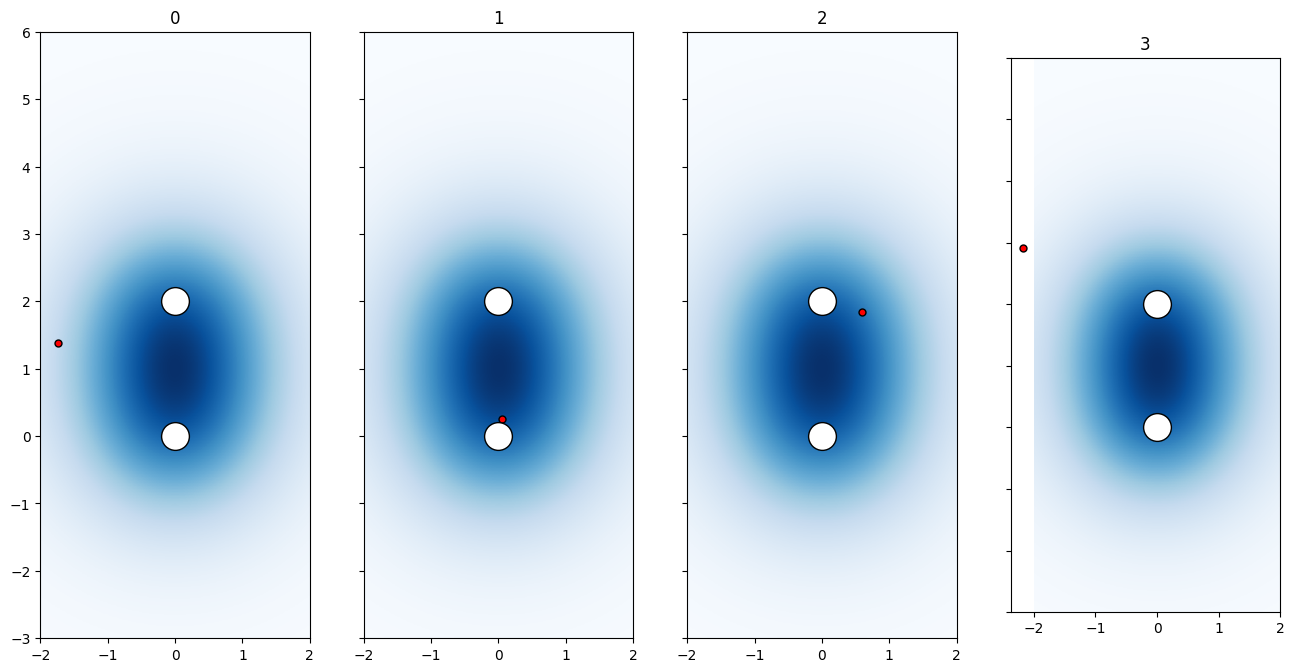

In [9]:
wf, _ = pyq.generate_slater(mol, mf)
coords, wfval, X, Y = run_scan(mol, wf)
make_plot(coords, wfval, X, Y)

## Checkpoint questions: 

1. Does the conditional wave function depend on the position of the other electron?
2. Do you see the bonding orbital? 
3. Given the form of the wave function, what function are we plotting here? 


## Introducing correlation into the calculation.
$$
\Psi(r_1, r_2) \simeq a_1 \phi_1(r_1) \phi_1(r_2) + a_2 (\phi_1(r_1) \phi_2(r_2) + \phi_1(r_2) \phi_2(r_1)) + a_3 \phi_2(r_1) \phi_2(r_2)
$$

In [10]:
mc = pyscf.mcscf.CASSCF(mf, 2, 2)
mc.kernel()



******** <class 'pyscf.mcscf.mc1step.CASSCF'> ********
CAS (1e+1e, 2o), ncore = 0, nvir = 8
max_cycle_macro = 50
max_cycle_micro = 4
conv_tol = 1e-07
conv_tol_grad = None
orbital rotation max_stepsize = 0.02
orbital rotation threshold for CI restart = 0.01
augmented hessian ah_max_cycle = 30
augmented hessian ah_conv_tol = 1e-12
augmented hessian ah_linear dependence = 1e-14
augmented hessian ah_level shift = 1e-08
augmented hessian ah_start_tol = 2.5
augmented hessian ah_start_cycle = 3
augmented hessian ah_grad_trust_region = 3
kf_trust_region = 3
kf_interval = 4
ci_response_space = 4
ci_grad_trust_region = 3
with_dep4 0
natorb = False
canonicalization = True
sorting_mo_energy = False
ao2mo_level = 2
chkfile = /content/tmp9r9agbdf
max_memory 4000 MB (current use 231 MB)
internal_rotation = False
******** <class 'pyscf.fci.direct_spin1.FCISolver'> ********
max. cycles = 50
conv_tol = 1e-08
davidson only = False
linear dependence = 1e-12
level shift = 0.001
max iter space = 12
max_mem

(-1.1198883155165016,
 -1.6198883155165016,
 FCIvector([[ 9.84455957e-01, -3.72492056e-12],
            [-3.72491937e-12, -1.75631626e-01]]),
 array([[ 6.64773657e-01, -1.27663924e+00, -1.56424607e+00,
         -1.40135693e+00,  7.07261028e-14,  2.46889637e-14,
          8.12186034e-01,  1.00987652e-14,  2.01675017e-14,
          1.09911173e+00],
        [-1.08097206e-01,  2.91486764e-01,  1.62467968e+00,
          2.57330521e+00, -6.26805755e-14, -1.92944548e-14,
         -6.80301909e-01, -6.10318043e-15, -1.42302957e-14,
         -1.84672313e-01],
        [ 1.39164481e-15,  2.54481211e-14,  1.95857441e-16,
          1.15462109e-14,  3.70832947e-01,  5.19423943e-01,
          2.69847323e-16,  7.93270447e-01, -1.34185328e-01,
          2.82958789e-15],
        [ 2.36241882e-15,  2.64801416e-14,  1.38476320e-16,
          1.15568107e-14,  5.19423943e-01, -3.70832947e-01,
         -5.58719987e-16,  1.34185328e-01,  7.93270447e-01,
          4.04381831e-15],
        [ 1.60126112e-02,  2.5

## Plotting 

In [11]:
mc.ci

FCIvector([[ 9.84455957e-01, -3.72492056e-12],
           [-3.72491937e-12, -1.75631626e-01]])

In [12]:
mc.e_tot

-1.1198883155165016

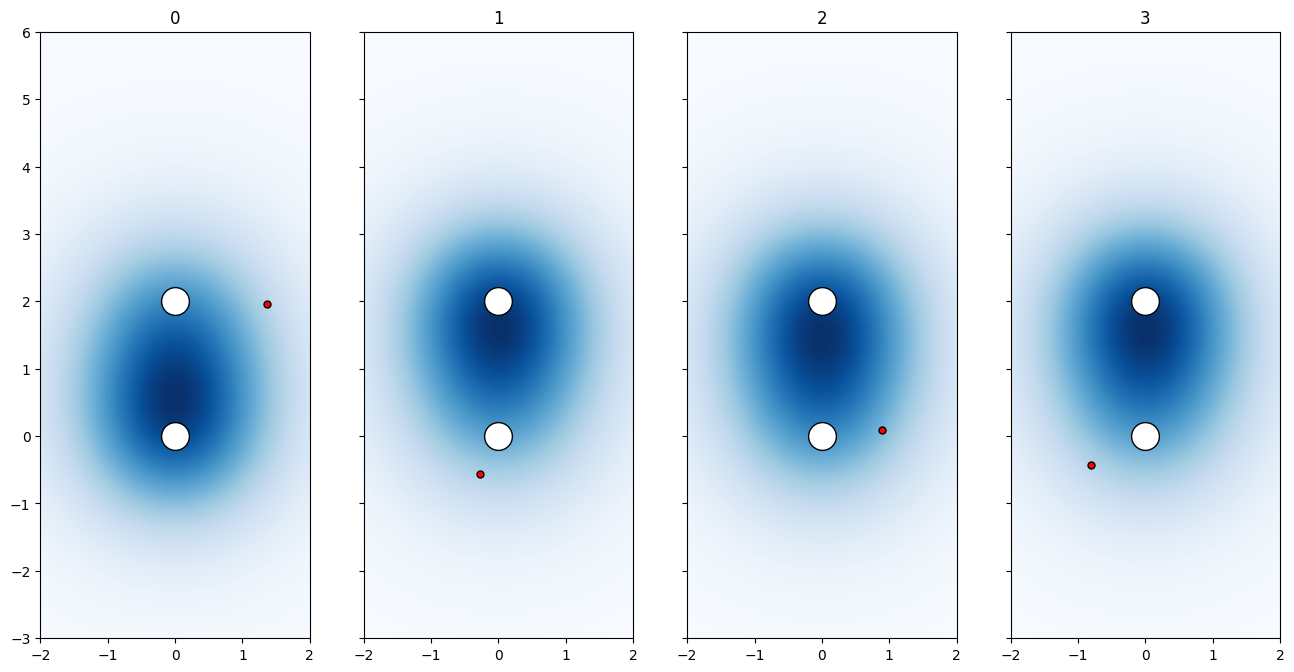

In [13]:
wf, _ = pyq.generate_slater(mol, mf, mc=mc)
coords, wfval, X, Y = run_scan(mol, wf)
make_plot(coords, wfval, X, Y)

## Checkpoint questions

1. Does the energy decrease from the Hartree-Fock solution? 
2. Do you know if this is close to the exact solution? 

## Slater-Jastrow

$$
\Psi_{CI} e^U,
$$
where $U$ depends explicitly on electron-electron distances


In [14]:
wf, to_opt = pyq.generate_wf(mol, mf, mc=mc)
grad =pyq.gradient_generator(mol, wf, to_opt)
coords = pyq.initial_guess(mol, 500)
wf, data = pyq.line_minimization(wf, coords, grad, verbose=True, max_iterations=10)

starting warmup
finished warmup
----------vmc done
descent en -1.1260270860202584 0.0007814899637157696  estimated sigma  0.17474646826023052
descent |grad| 0.0536349922342264
----------vmc done
descent en -1.1269764488931815 0.0012337417573024616  estimated sigma  0.2758730436008352
descent |grad| 0.03683639585331321
----------vmc done
descent en -1.1283175751296768 0.0011899258212927555  estimated sigma  0.2660755024592868
descent |grad| 0.02608406629027507
----------vmc done
descent en -1.1278035305064689 0.0009303463455389955  estimated sigma  0.20803176712437024
descent |grad| 0.020715047688410614
----------vmc done
descent en -1.1283737849760993 0.0007234776845589403  estimated sigma  0.16177452828779404
descent |grad| 0.02148494886847424
----------vmc done
descent en -1.1293633221591564 0.001229147285485375  estimated sigma  0.274845688470464
descent |grad| 0.01649529129486597
----------vmc done
descent en -1.1290901009774688 0.0009190055294654346  estimated sigma  0.20549588355

final energy -1.127913197405409 +/- 0.0009041327562625445


Text(0, 0.5, 'Energy (Ha)')

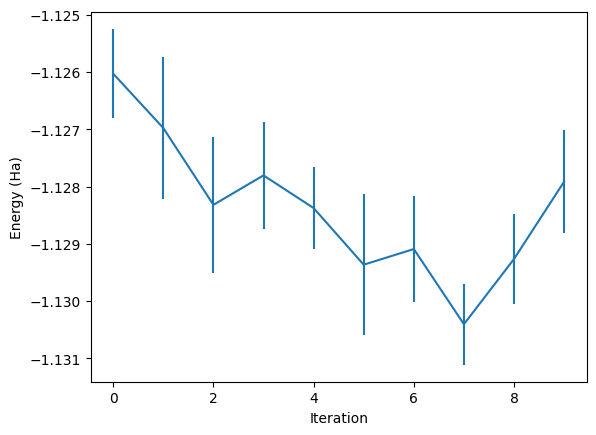

In [15]:
en = [d['energy'] for d in data]
errorbars = [d['energy_error'] for d in data]
iteration = [d['iteration'] for d in data]
print("final energy", en[-1], "+/-", errorbars[-1])
plt.errorbar(iteration, en, errorbars)
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")

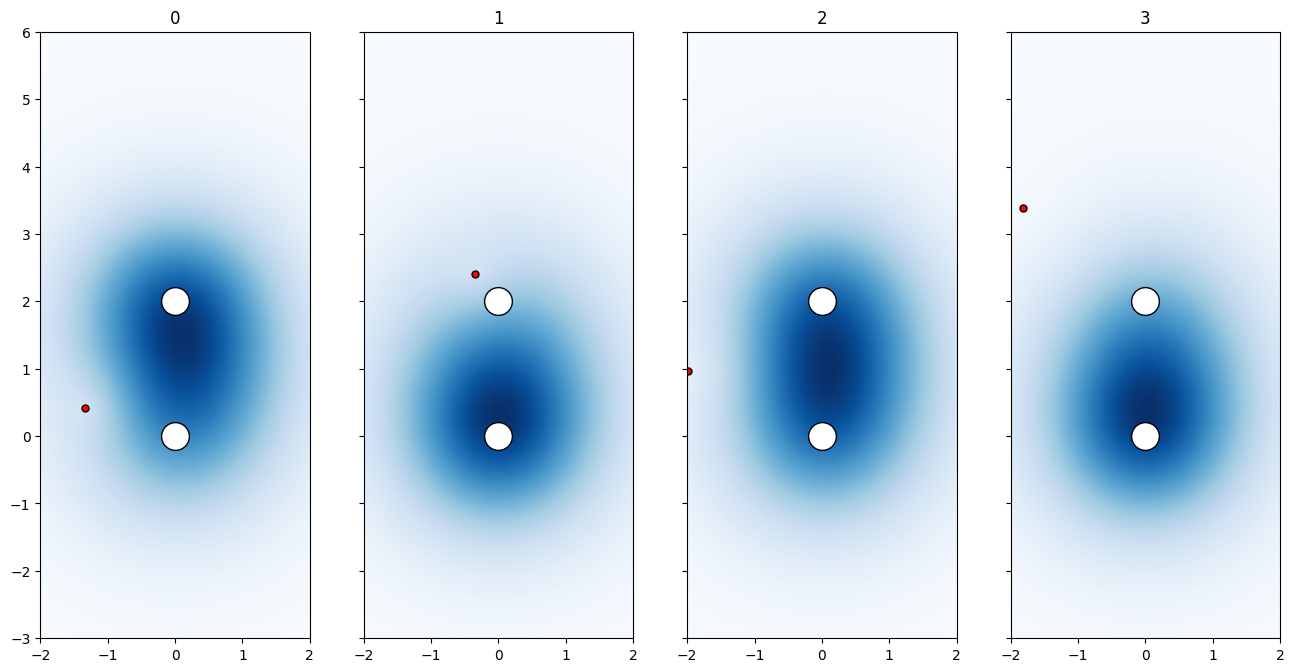

In [16]:
coords, wfval, X, Y = run_scan(mol, wf)
make_plot(coords, wfval, X, Y)

## Checkpoint questions

1. Note the VMC calculation has error bars. The energy might not 
2. What is the ordering of energy? Make a plot of the energy versus the wave function ansatz. 
3. What changed about the wave function as you included more correlation? 
4. Try a few more interatomic distances, say r=1.1 Bohr and 4.0 Bohr. What changes in the relative energies of these wave functions and the correlations? 


## Exact solution using diffusion Monte Carlo

Since the wave function is implicit in the walker distribution, we cannot make the conditional wave function plots from the DMC solution, at least not easily.

In [17]:
dmc_data, coords, weights = pyq.rundmc(wf, coords, tstep=0.1, accumulators={'energy':pyq.EnergyAccumulator(mol)})

In [18]:
blocks = pyq.avg_reblock(dmc_data['energytotal'], nblocks=10)
print("Exact result: ", np.mean(blocks), "+/-", np.std(blocks)/np.sqrt(len(blocks)))

Exact result:  -1.1372856748777018 +/- 0.0035679164760954386
